# Explainable Options Pricing Modeling

## Overview
This project implements explainable models focusing on the pricing of financial derivatives, specifically various types of options. The key features of this project include handling American exercise rights, dividends, stochastic volatility, and types of exotic options. 

## Objectives
- **Enhance Interpretability**: By providing detailed explanations and comparisons of different pricing models, this project aims to make the pricing of options more understandable rather than just using esoteric closed formulas (though we do use these as a benchmark).
- **Expand Core Binomial Model**: Enhance the core binomial model to accommodate real-world complexities such as dividend-paying stocks, American options, and stochastic volatility. This enhancement addresses limitations of the basic model and improves accuracy by reflecting more realistic market conditions. Incorporating dividends ensures that the model accurately captures the impact of cash payouts to shareholders on option prices. Integrating American options capability enables the pricing of options with early exercise features, which is crucial for accurately valuing options in markets with uncertain future volatility. Additionally, incorporating stochastic volatility models allows for better representation of the volatility dynamics observed in real markets, leading to more accurate pricing predictions.
- **Price Complex Exotics**: Develop models capable of pricing complex exotic options. These options often possess intricate payoff structures and features, making them challenging to price accurately. By developing models that can accurately price these exotic options while maintaining interpretability, this project aims to simplify the understanding of complex option pricing and reduce the complexity involved in explaining the details of their pricing mechanisms.

## Methodology
1. **Binomial Model Enhancements**: Implements a binomial model that supports dividends and American options, providing early exercise features which are crucial for accurate option pricing.
2. **Stochastic Volatility Modeling**: Uses the Heston model to simulate paths with stochastic volatility, addressing the limitations of the Black-Scholes model in environments where volatility is not constant.
3. **Barrier and Digital Options**: Incorporates pricing for barrier and digital options using Monte Carlo methods.
4. **Explicit Formulas**: Wherever possible, uses explicit formulas for validation and comparison to ensure the reliability of the simulation-based methods.
5. **Visualizations**: Include visualizations that allow for the visual representation and explanation of the complex options pricing models.

## What is an Option?
An option is a financial derivative that gives the buyer the right, but not the obligation, to buy (in the case of a call option) or sell (in the case of a put option) an underlying asset at a predetermined price (called the Strike price) on (European option) or anytime before (American option) an expiry date. Options are used for hedging against risks, speculating on future price movements, or enhancing investment income.

The two main types of options are calls and puts. Furthermore, there are several flavors of options. The ones we will be considering in the project are:
- **European options**: A European option is the most standard option and can only be exercised at the end of its life, at its expiration.
- **American options**: Similar to the European option, but it can be exercised at any time before and including the day of expiration.
- **Digital options**: Also known as a binary option, this pays out a fixed amount if the underlying asset is above (call) or below (put) a certain price at expiration.
- **Barrier options**: A type of option where the payoff depends on whether the underlying asset's price reaches a certain level (the barrier) during a specific period.

## Option class
The `Option` class, which is very simple, encapsulates all the necessary attributes required to price an option:
- **$S_0$ (float)**: Current price of the underlying asset.
- **$K$ (float)**: Strike price of the option.
- **$T$ (float)**: Time to expiration of the option, measured in years.
- **vol $(\sigma)$ (float)**: Volatility of the underlying asset.
- **div (float)**: Dividend yield of the underlying asset, defaulting to 0 if not provided.
- **is_call (bool)**: A boolean indicating if the option is a call (True) or a put (False).
- **barrier (float)**: The barrier level for barrier options, applicable only if the option is a barrier type.
- **option_type (str)**: The type of the option e.g. "European".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class Option:
    """
    Represents an options contract, encapsulating all the necessary attributes 
    required for pricing models and simulations across different types of options.

    Attributes:
        S0 (float): The current price of the underlying asset.
        K (float): The strike price of the option.
        T (float): The time to expiration of the option, measured in years.
        vol (float): The volatility of the underlying asset, expressed as a decimal.
        div (float, optional): The dividend yield of the underlying asset, expressed as a decimal.
                               Defaults to 0 if not provided.
        is_call (bool): A boolean indicating if the option is a call (True) or a put (False).
                        Defaults to True (call option).
        barrier (float, optional): The barrier level for barrier options. If not a barrier option,
                                   this should be None.
        option_type (str): The type of the option. Possible types include 'European', 'American',
                           'Barrier', etc. Defaults to 'European'.

    Examples:
        >>> european_call = Option(spot_price=100, strike=100, maturity=1, volatility=0.2)
        >>> american_put = Option(spot_price=100, strike=100, maturity=1, volatility=0.2, 
                                  is_call=False, option_type='American')
        >>> barrier_call = Option(spot_price=100, strike=100, maturity=1, volatility=0.2,
                                  barrier=110, option_type='Barrier')
    """
    def __init__(self, spot_price, strike, maturity, volatility, dividend_yield = 0, is_call=True, barrier=None, option_type='European'):
        self.S0 = spot_price  
        self.K = strike 
        self.T = maturity 
        self.vol = volatility 
        self.div = dividend_yield 
        self.is_call = is_call  
        self.barrier = barrier 
        self.option_type = option_type 
    

# Binomial Model for Option Pricing

## Overview
The Binomial Model is a fundamental method for pricing options that relies on discretizing the time to expiration into several intervals or steps. It constructs a binomial tree representing possible paths the underlying asset's price might take until expiration. This model is particularly versatile as it can easily be extended to accommodate dividends and early exercise features, making it suitable for pricing American options in addition to just European options.


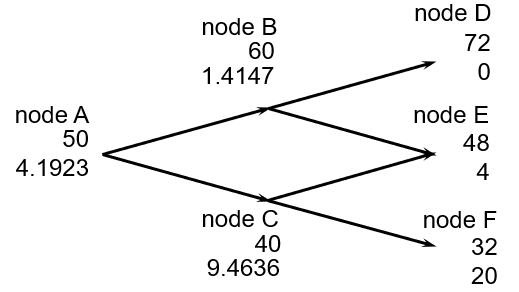

## Mathematical Framework
1. **Tree Construction**:
   - Each node in the binomial tree represents a possible price of the underlying asset at a given time.
   - Starting from the current stock price ($S_0$), the price at each subsequent node can move up or down by a factor derived from the volatility of the stock and the time step size.
   - The up-factor ($u$) and down-factor ($d$) are calculated as follows:
     - **Up-factor (u)** = $e^{(\text{volatility} \times \sqrt{\Delta t})}$
     - **Down-factor (d)** = $\frac{1}{u}$

2. **Risk-Neutral Probability**:
   - The probability of the price moving up or down is determined under the risk-neutral measure, which assumes investors are indifferent to risk and thus no excess return is earned.
   - The risk-neutral probability ($p$) is calculated as:
     - $p = \frac{\exp((r - q) \Delta t) - d}{u - d}$

3. **Price Calculation**:
   - The option price is calculated by working backwards from the leaf nodes (expiration) to the root (today).
   - At each node, the expected option value is computed using the risk-neutral probabilities of moving up or down.

4. **Dividend Adjustments**:
   - Dividends reduce the expected return on the stock, hence they are factored into the risk-neutral probability calculation.
   - The impact of dividends is modeled by adjusting the risk-free rate downwards by the dividend yield in the formula for $p$.

5. **Handling American Options**:
   - American options can be exercised at any time up to and including the day of expiration, which requires an additional check at each node:
     - For each node, compare the immediate exercise value (intrinsic value) with the expected value of holding the option.
     - The value of the option at each node is the maximum of these two values.

## Visualization
- The model includes a visualization of the binomial tree, showing the potential paths the stock price could take and the corresponding option values at each node.
- Nodes where early exercise is optimal (for American options) are highlighted, providing clear visual cues for decision-making points in the option's life.
- The binomial model is perfect for explainability, as you can see the current option price at every possible time/node.


In [2]:
class BinomialModel:
    """
    A class that models the pricing of options using the binomial options pricing model.
    It constructs a binomial tree to represent possible paths the stock price can take over time.
    The option price is calculated by working backwards from the final possible stock prices at expiration.
    """
    
    def __init__(self, option, risk_free_rate, num_time_steps=1000):
        """
        Initializes the model with an option, risk-free rate, and number of time steps for the binomial tree.
        
        :param option: An instance of the Option class representing the option to be priced.
        :param risk_free_rate: The risk-free interest rate.
        :param num_time_steps: The number of time steps to be used in the binomial tree.
        """
        self.option = option  # The option to be priced.
        self.r = risk_free_rate  # The annual risk-free interest rate.
        self.num_time_steps = num_time_steps  # The number of steps in the binomial tree.
        self.V = np.zeros((num_time_steps + 1, num_time_steps + 1))  # The binomial tree of option values.

    def get_price(self):
        """
        Prices the option using the binomial tree and returns the estimated price.
        """
        o = self.option
        dT = o.T / self.num_time_steps  # The time delta per step.
        u = np.exp(o.vol * np.sqrt(dT))  # The up factor per step.
        d = 1 / u  # The down factor per step.
        p = (np.exp((self.r - o.div) * dT) - d) / (u - d)  # The risk-neutral probability of an up move.

        # Initialize final stock prices and option values at maturity.
        stock_prices_at_maturity = o.S0 * u**np.arange(self.num_time_steps, -1, -1) * d**np.arange(0, self.num_time_steps + 1)
        self.V[:, self.num_time_steps] = np.maximum(0, stock_prices_at_maturity - o.K if o.is_call else o.K - stock_prices_at_maturity)

        # Iterate backwards through the tree to calculate option values.
        for step in reversed(range(self.num_time_steps)):
            stock_prices = o.S0 * u**np.arange(step, -1, -1) * d**np.arange(0, step + 1)
            option_values = np.exp(-self.r * dT) * (p * self.V[:step + 1, step + 1] + (1 - p) * self.V[1:step + 2, step + 1])

            # Check for early exercise for American options.
            if o.option_type == "American":
                intrinsic_values = np.maximum(0, stock_prices - o.K if o.is_call else o.K - stock_prices)
                self.V[:step + 1, step] = np.maximum(option_values, intrinsic_values)
            else:
                self.V[:step + 1, step] = option_values
        
        # Print a statement about the binomial tree visual representation.
        print("Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).")
        
        # Indicate the potential for early exercise in American options.
        if o.option_type == "American":
            print("Any nodes colored green indicate that early exercise at that node is optimal.")
            
        # Visualize the binomial tree.
        self.visualize_tree()
        
        # Indicate how the option price is determined.
        print("The value of the option will be the value of V in the first node, which has been computed via backwards induction.")
        print(f'Therefore, the binomial model prices the option at ${self.V[0][0]}')
        
        return self.V[0, 0]  # Return the option price at t=0, which is the current price.
    
    def visualize_tree(self, num_levels=7):
        """
        Visualizes the binomial tree up to a certain level using matplotlib and networkx.
        
        :param num_levels: The number of levels of the tree to visualize.
        """
        num_levels = min(num_levels, self.num_time_steps)  # Ensure we don't exceed the number of time steps.
        o = self.option  # Shortcut to the option object.
        dT = float(o.T / self.num_time_steps)  # Time delta per step.
        u = np.exp(o.vol * np.sqrt(dT))  # Up factor per step.
        d = 1 / u  # Down factor per step.
        p = (np.exp((self.r - o.div) * dT) - d) / (u - d)  # Risk-neutral probability.

        # Initialize graph, positions, labels, and colors for visualization.
        G = nx.DiGraph()
        pos = {}
        labels = {}
        node_colors = [] 

        # Populate the graph with nodes and labels.
        for i in range(num_levels + 1):
            for j in range(i + 1):
                stock_price = o.S0 * (u ** j) * (d ** (i - j))
                option_value = self.V[i - j, i]
                intrinsic_value = max(0, stock_price - o.K if o.is_call else o.K - stock_price)
                
                # Determine if early exercise is optimal for American options.
                early_exercise = (option_value == intrinsic_value and option_value != 0) if o.option_type == "American" else False
                node_label = f"S={stock_price:.2f}\nV={option_value:.2f}"
                node_color = 'lightgreen' if early_exercise else 'lightblue'
                node_colors.append(node_color)

                pos[(i, j)] = (i, 2 * (j - i / 2))  # Position nodes for visualization.
                labels[(i, j)] = node_label
                G.add_node((i, j), label=node_label)

                # Connect nodes with directed edges to represent possible stock price movements.
                if i < num_levels:
                    G.add_edge((i, j), (i + 1, j), label=f"{1-p:.4f}".lstrip('0'))
                    G.add_edge((i, j), (i + 1, j + 1), label=f"{p:.4f}".lstrip('0'))

        # Display the binomial tree graph.
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, node_color=node_colors, with_labels=True, labels=labels, node_size=2000, font_size=8)
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
        plt.axis('off')
        plt.show()

# Validation with Black-Scholes Model

To ensure the accuracy of our binomial model for European options, we utilize the Black-Scholes formula as a benchmark. The Black-Scholes model provides a theoretical estimate for the prices of European-style options and thus serves as a crucial validation tool for comparing our model's outputs.

## Black-Scholes Formulas

- **European Call Option Price**:
  $$C = S e^{-qT} N(d_1) - K e^{-rT} N(d_2)$$
- **European Put Option Price**:
  $$P = K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1)$$

Where:
- $S$ is the current stock price.
- $K$ is the strike price.
- $T$ is the time to expiration.
- $r$ is the risk-free interest rate.
- $q$ is the dividend yield.
- $\sigma $ is the volatility of the stock.
- $N$ is the cumulative distribution function of the standard normal distribution.
- $d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r - q + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}$
- $d_2 = d_1 - \sigma\sqrt{T}$


In [3]:
from scipy.stats import norm
N = norm.cdf

# Calculate the price of a European call option using the Black-Scholes formula.
def BS_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return S*np.exp(-q*T) * N(d1) - K * np.exp(-r*T)* N(d2)

# Calculate the price of a European put option using the Black-Scholes formula.
def BS_put(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*np.exp(-q*T)*N(-d1)

# Testing the Binomial Model Against Black-Scholes

## Setting Up the Option Parameters
We first consider a European call option (no dividends) with the following characteristics:
- **Spot Price (S0)**: \$100
- **Strike Price (K)**: $98
- **Maturity (T)**: 1.5 years
- **Volatility (σ)**: 30%
- **Risk-Free Rate (r)**: 10%
- **Dividend Yield (q)**: 0%


Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).


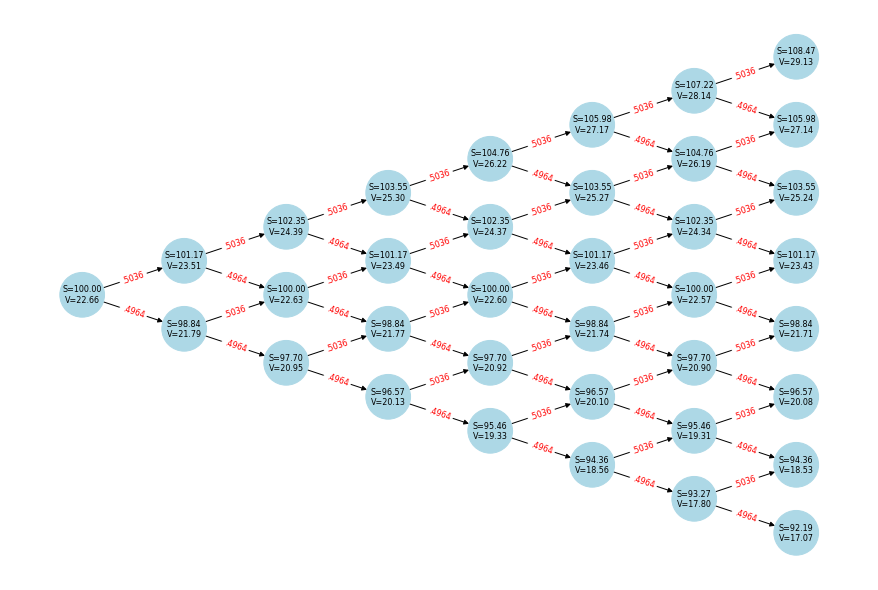

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $22.656206613452163


Black-Scholes prices the option at $22.656946677174595


In [4]:
o = Option(spot_price = 100, strike = 98, maturity = 1.5, volatility = 0.3, dividend_yield = 0, is_call = True, option_type="European")
b = BinomialModel(option = o, risk_free_rate = 0.1)
b.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_call(o.S0, o.K, o.T, b.r, o.div, o.vol)}')

The output above provides a detailed visualization of the binomial tree, where each node represents a possible future price of the underlying asset and the corresponding option value. Following the tree structure from the leaves back to the root, we arrive at the present value of the option using a backward induction approach. The final price computed by our Binomial Model for the European call option is displayed at the top of the tree. This output makes it very easy to see where the options prices are coming from and shows the entire decision-making process from the bottom-up.

We can see that price produced by our binomial model is very close to the price produced by the BS formula, so our model is correctly pricing the option.

## Testing the model when there are dividends
Now, we consider a European call option that pays dividends:

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).


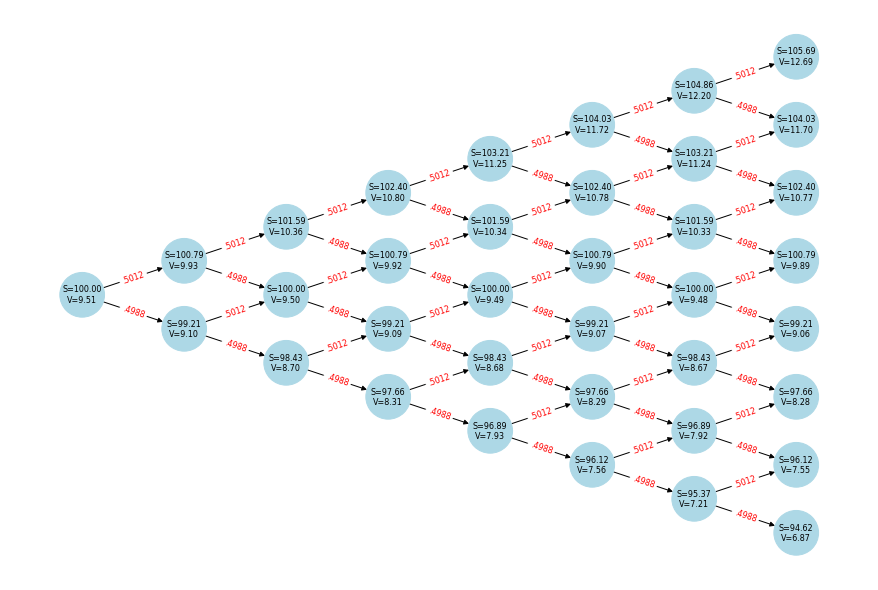

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $9.513315036102487


Black-Scholes prices the option at $9.514388963641053


In [5]:
o = Option(spot_price = 100, strike = 105, maturity = 1, volatility = 0.25, dividend_yield = 0.05, is_call = True, option_type="European")
b = BinomialModel(option = o, risk_free_rate = 0.1)
b.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_call(o.S0, o.K, o.T, b.r, o.div, o.vol)}')

Once again, our model outputs the tree and produces the correct price. Now we try pricing a European put:

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).


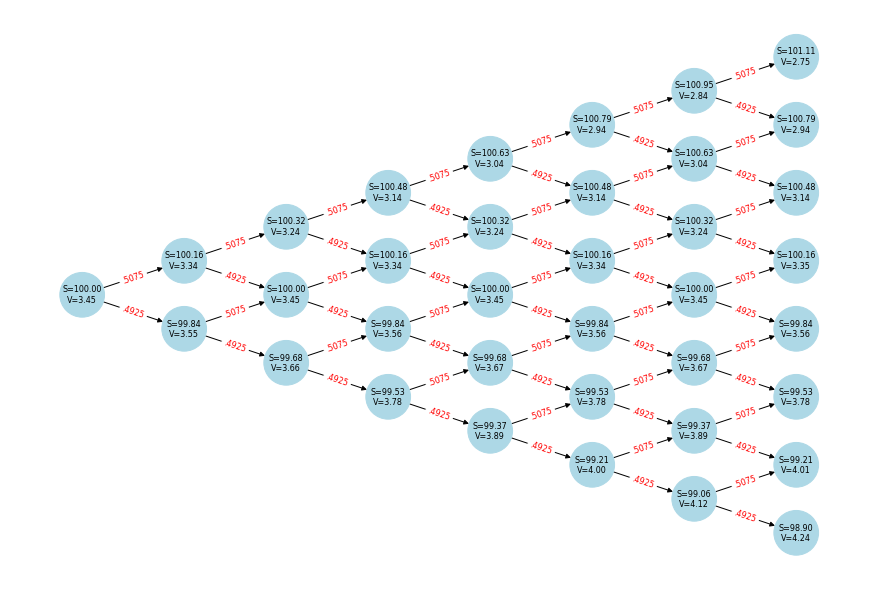

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $3.4465216155787983


Black-Scholes prices the option at $3.446492799303016


In [6]:
o = Option(spot_price = 100, strike = 105, maturity = 0.25, volatility = 0.1, dividend_yield = 0, is_call = False, option_type="European")
b = BinomialModel(option = o, risk_free_rate = 0.1)
b.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_put(o.S0, o.K, o.T, b.r, o.div, o.vol)}')

The prices are nearly the same once again. Finally, we price a European put that pays dividends.

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).


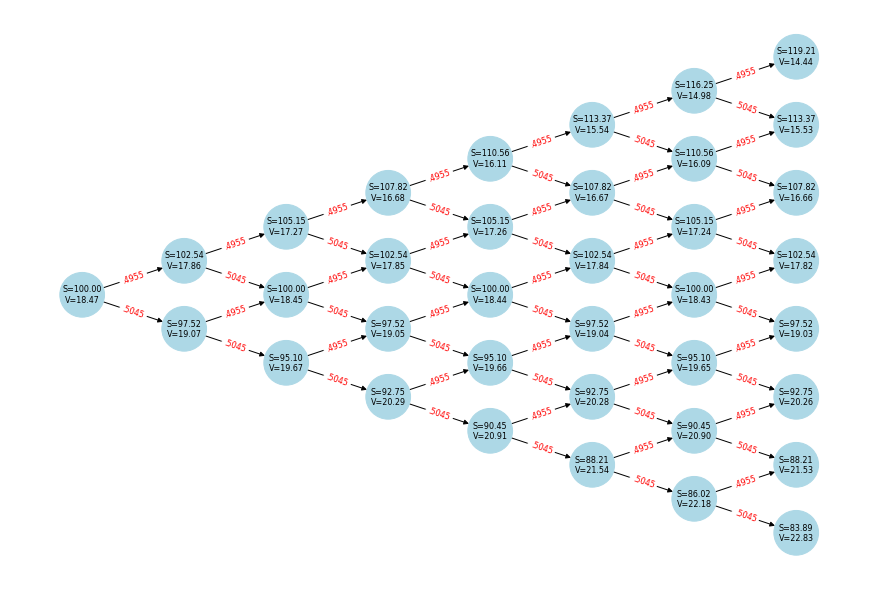

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $18.467453309742844


Black-Scholes prices the option at $18.4695288341238


In [7]:
o = Option(spot_price = 100, strike = 90, maturity = 1.75, volatility = 0.6, dividend_yield = 0.05, is_call = False, option_type="European")
b = BinomialModel(option = o, risk_free_rate = 0.1)
b.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_put(o.S0, o.K, o.T, b.r, o.div, o.vol)}')

Perfect! Our model works for both European calls and puts, including those that pay dividends. 

# Testing American Options: Longstaff-Schwartz Method

Unlike European options, American options do not have a closed-form solution due to the additional complexity. However, it would still be nice to have some benchmark to make sure our model works for American options. The Longstaff-Schwartz algorithm is a Monte Carlo simulation-based method designed to price American options by simulating a multitude of possible paths for the underlying asset's price and determining the optimal exercise strategy at each step.

## Simulation via Geometric Brownian Motion
The underlying asset price paths are simulated using the Geometric Brownian Motion (GBM) model, defined by the stochastic differential equation:

$$dS_t = \mu S_t dt + \sigma S_t dW_t $$

where:
- $S_t$ is the stock price at time $t$.
- $\mu$ is the expected return (drift coefficient).
- $\sigma$ is the volatility (diffusion coefficient).
- $W_t$  is a Wiener process or Brownian motion.

For simulation purposes, this is discretized over time steps $\Delta t$, resulting in a log-normal distribution for stock prices at each step.

## Algorithmic Steps and Mathematical Formulas
1. **Path Initialization**: Simulate log-returns of asset price using:
   $$\Delta S = (r - q - \frac{\sigma^2}{2}) \Delta t + \sigma \sqrt{\Delta t} Z $$
   where $Z$ is drawn from a standard normal distribution.
   
   
2. **Intrinsic Value**: At each step, compute the option's intrinsic value based on the simulated stock price:

   $ \text{Intrinsic Value} = \max(S - K, 0) \text{ for a call, or } \max(K - S, 0) \text{ for a put}$


3. **Optimal Exercise and Continuation Value**:
   - Estimate continuation value using least squares regression against the in-the-money paths.
   - Decide whether to exercise early by comparing intrinsic value with estimated continuation value.


4. **Backward Induction**: Iteratively determine the option value at each step, moving backward from expiration to the present.

5. **Option Pricing**: The final price is calculated by averaging the discounted payoffs across all simulated paths.

Note: given the computational constraints, the number of simulations is restricted, and thus, the option pricing may carry some estimation error.

In [8]:
def Longstaff_Schwartz(S0, K, T, r, q, sigma, is_call, num_steps=2000, paths=20000):
    """
    Implements the Longstaff-Schwartz algorithm for American option pricing using Monte Carlo simulation.

    This function simulates multiple possible paths for the underlying asset's price, determines the 
    optimal exercise times using least squares regression, and calculates the option's price.
    """
    # Calculate the time step size.
    dt = T / num_steps

    # Initialize price paths and simulate log returns.
    starting_paths = np.zeros((paths, 1))
    increments = norm.rvs(size=(paths, num_steps - 1), loc=(r - q - 0.5 * sigma**2) * dt, scale=sigma * np.sqrt(dt))
    log_price_paths = np.concatenate((starting_paths, increments), axis=1).cumsum(axis=1)
    price_paths = S0 * np.exp(log_price_paths)

    # Calculate the intrinsic value at each step for all paths.
    intrinsic_values = np.maximum(price_paths - K, 0) if is_call else np.maximum(K - price_paths, 0)
    option_prices = np.zeros_like(intrinsic_values)
    option_prices[:, -1] = intrinsic_values[:, -1]  # Set the final values to the intrinsic values at maturity.

    # Determine optimal exercise strategy via regression and backward induction.
    for step in reversed(range(1, num_steps - 1)):
        in_the_money = intrinsic_values[:, step] > 0  # Filter in-the-money paths.
        # Perform regression on in-the-money paths to estimate continuation values.
        regression = np.polyfit(price_paths[in_the_money, step], option_prices[in_the_money, step + 1] * np.exp(-r * dt), deg=2)
        continuation_values = np.polyval(regression, price_paths[in_the_money, step])

        # Identify optimal exercise times based on comparison of intrinsic and continuation values.
        optimal_exercise_times = np.zeros(len(in_the_money), dtype=bool)
        optimal_exercise_times[in_the_money] = intrinsic_values[in_the_money, step] > continuation_values

        # Update the option prices for paths where exercising is optimal.
        option_prices[optimal_exercise_times, step] = intrinsic_values[optimal_exercise_times, step]
        # Zero out future values after exercise.
        option_prices[optimal_exercise_times, step + 1 :] = 0
        
        # Update prices for paths where exercise is not optimal (discount to present value).
        non_exercise_times = option_prices[:, step] == 0
        option_prices[non_exercise_times, step] = np.exp(-r * dt) * option_prices[non_exercise_times, step + 1]

    # Calculate the average discounted payoff to estimate the option price.
    return np.exp(-r * dt) * np.mean(option_prices[:, 1])

Now, let's test our model on an American call option that does not pay dividends. Note that American and European calls on a nondividend stock always have the same value, so we can also use Black Scholes as a comparison point. This is because exercising a call before expiration discards the time value inherent in the option. The only offsetting benefit from early exercise arises from an attempt to capture a dividend. If there is no dividend, there is no incentive to early exercise, so the early exercise feature of an American call on a nondividend stock has no value.

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).
Any nodes colored green indicate that early exercise at that node is optimal.


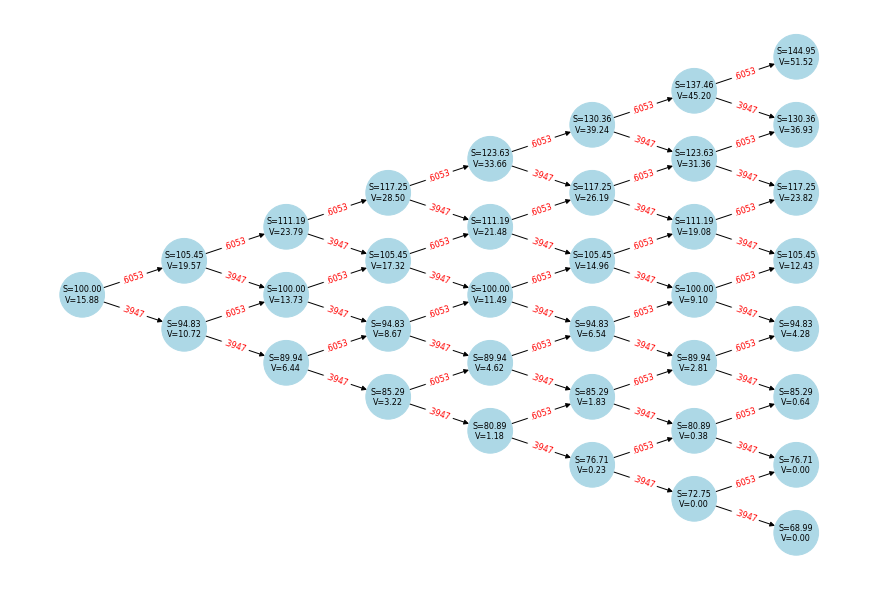

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $15.877516751058618


Longstaff-Schwartz prices the option at $16.033894325241786
Black-Scholes prices the option at $15.87733712872354


In [9]:
o = Option(spot_price = 100, strike = 97, maturity = 1.25, volatility = 0.15, dividend_yield = 0, is_call = True, option_type="American")
b = BinomialModel(option = o, risk_free_rate = 0.1, num_time_steps=10)
b.get_price()
print(f'\n\nLongstaff-Schwartz prices the option at ${Longstaff_Schwartz(o.S0, o.K, o.T, b.r, o.div, o.vol, o.is_call)}')
print(f'Black-Scholes prices the option at ${BS_call(o.S0, o.K, o.T, b.r, o.div, o.vol)}')

We can see that our model produces nearly the same price as Black-Scholes. This output also shows that Longstaff-Schwartz, given computational limitations, can be a few cents off of the real price. Therefore, in future test cases, we just need to make sure that the Longstaff-Schwartz price is somewhat similar to the binomial model's price.

Now, let's test out model on a European call option that does pay dividends:

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).
Any nodes colored green indicate that early exercise at that node is optimal.


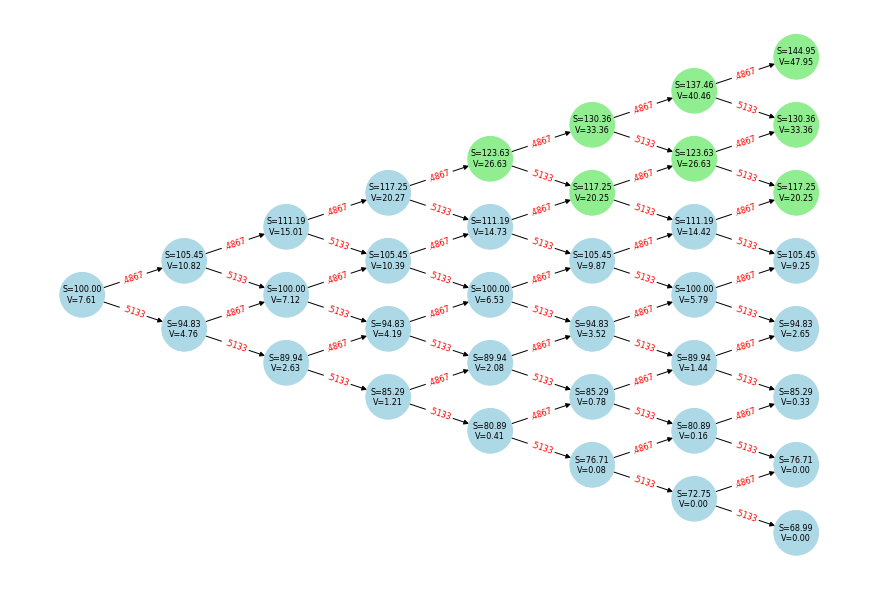

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $7.613494294497845


Longstaff-Schwartz prices the option at $7.48595555163755


In [10]:
o = Option(spot_price = 100, strike = 97, maturity = 1.25, volatility = 0.15, dividend_yield = 0.1, is_call = True, option_type="American")
b = BinomialModel(option = o, risk_free_rate = 0.1, num_time_steps=10)
b.get_price()
print(f'\n\nLongstaff-Schwartz prices the option at ${Longstaff_Schwartz(o.S0, o.K, o.T, b.r, o.div, o.vol, o.is_call)}')

We can see that our model is consistent with Longstaff-Schwartz, and thus, works for American calls with dividends. Also, the model allows for interpretability by coloring nodes green if early exercise is optimal.

Now, let's make sure that our model works for American puts as well. First, let's test an American put on a nondividend paying stock:

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).
Any nodes colored green indicate that early exercise at that node is optimal.


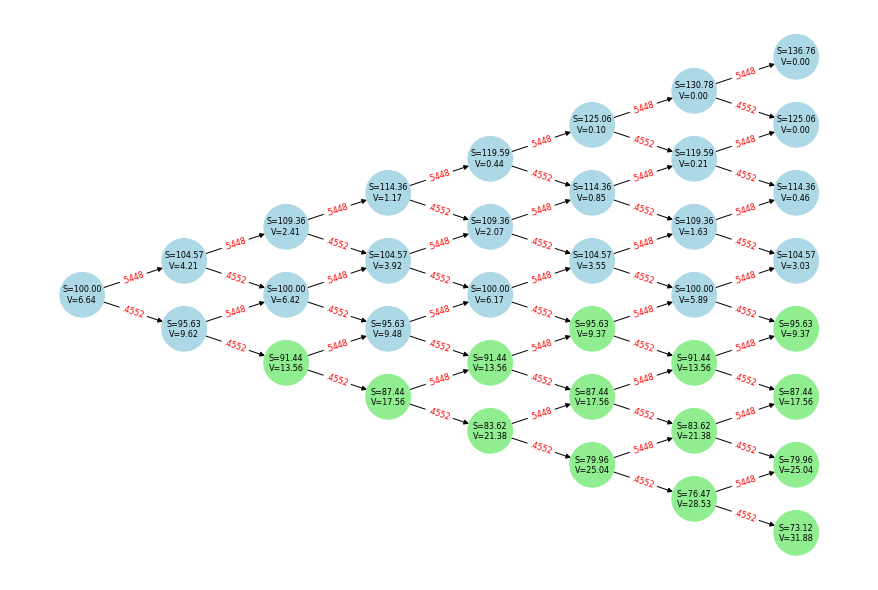

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $6.639873719308794


Longstaff-Schwartz prices the option at $6.5326390982334885


In [11]:
o = Option(spot_price = 100, strike = 105, maturity = 0.5, volatility = 0.2, dividend_yield = 0, is_call = False, option_type="American")
b = BinomialModel(option = o, risk_free_rate = 0.1, num_time_steps=10)
b.get_price()
print(f'\n\nLongstaff-Schwartz prices the option at ${Longstaff_Schwartz(o.S0, o.K, o.T, b.r, o.div, o.vol, o.is_call)}')

Once again, our model works. Now, let's test it for an American put on a dividend paying stock:

Below is a visual representation of the binomial tree for this option. Each node displays S (the spot stock price at the node) and V (the option price at the node).
Any nodes colored green indicate that early exercise at that node is optimal.


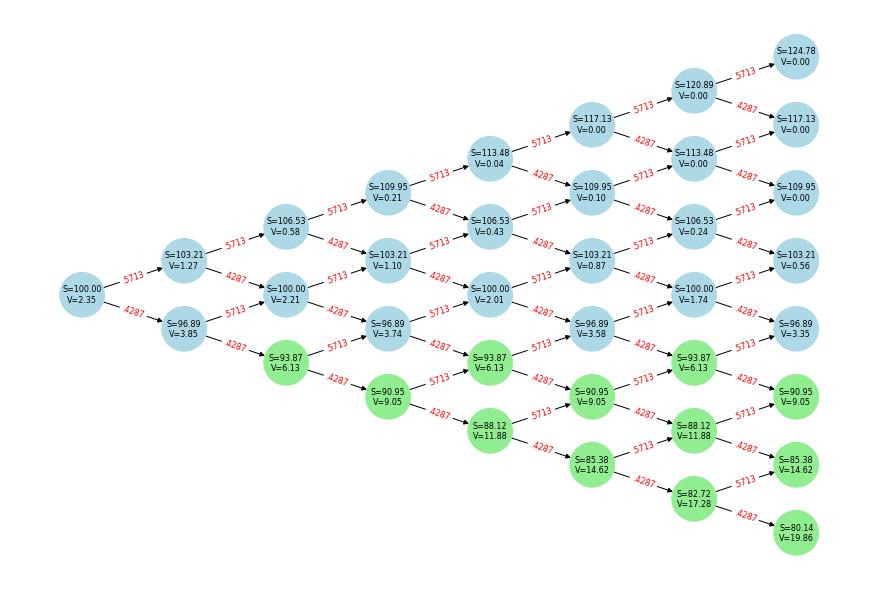

The value of the option will be the value of V in the first node, which has been computed via backwards induction.
Therefore, the binomial model prices the option at $2.350006046957798


Longstaff-Schwartz prices the option at $2.38831172850043


In [12]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.1, dividend_yield = 0.05, is_call = False, option_type="American")
b = BinomialModel(option = o, risk_free_rate = 0.1, num_time_steps=10)
b.get_price()
print(f'\n\nLongstaff-Schwartz prices the option at ${Longstaff_Schwartz(o.S0, o.K, o.T, b.r, o.div, o.vol, o.is_call)}')

Amazing! We can conclude that our improved binomial model is explainable, accomodates for dividend paying stocks, and works for both European and American options.

# Heston Model for European Option Pricing with Stochastic Volatility

## Motivation
In financial markets, volatility is a key factor affecting option prices. Traditional models, like the binomial model, assume static volatility, which can be an oversimplification. The Heston Model addresses this by introducing stochastic volatility, allowing volatility to fluctuate over time. This enhancement is crucial for accurately pricing European options, as it aligns the model more closely with real market behaviors where volatility is dynamic and uncertain.

## The Heston Model Explained
The Heston model is particularly well-suited for pricing European options, which do not have the early exercise feature of American options. It employs two stochastic processes: one for the underlying asset price and one for its variance, with the following dynamics:

$$
\begin{align*}
\text{Asset Price:} \quad dS_t &= r S_t dt + \sqrt{v_t} S_t dW_{S_t} \\
\text{Variance:} \quad dv_t &= \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_{v_t}
\end{align*}
$$

where:

- $S_t$ is the stock price at time $t$.
- $r$ is the risk-free interest rate.
- $v_t$ is the variance of the stock price at time $t$.
- $\kappa$ represents the rate at which variance reverts to its long-term mean $\theta$.
- $\theta$ is the long-term variance.
- $\sigma$ denotes the volatility of volatility.
- $\rho$ is the correlation coefficient between the Wiener processes $W_{S_t}$ and $W_{v_t}$.

## Simulation for Pricing
We utilize Monte Carlo simulation to generate paths for both the underlying asset's price and its variance. The option's value is then estimated by calculating the expected payoff across these paths and discounting it back at the risk-free rate.

In [13]:
import scipy.stats as ss
from tqdm import tqdm

class HestonModel:
    """
    Simulates the stock price paths under the Heston model of stochastic volatility and prices European options.
    """
    def __init__(self, option, risk_free_rate, kappa, theta, sigma, rho, num_time_steps=1400, num_paths=1400):
        """
        Initializes the Heston model with parameters and option details.

        Parameters:
        - option: The option object containing base parameters like strike price and initial stock price.
        - risk_free_rate: The risk-free interest rate.
        - kappa: Rate at which volatility reverts to theta.
        - theta: Long-term volatility level.
        - sigma: Volatility of volatility.
        - rho: Correlation between stock and volatility.
        - num_time_steps: Number of discrete time steps in the simulation.
        - num_paths: Number of paths to simulate.
        """
        self.option = option
        self.r = risk_free_rate
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.v0 = option.vol
        self.num_time_steps = num_time_steps
        self.num_paths = num_paths
        if option.option_type != "European":
            raise ValueError("The Heston model only works for European options.")

    def Heston_paths(self):
        """
        Generates paths for stock price and volatility using the Heston model.
        
        Returns:
        - Tuple of arrays for final stock prices, final volatilities, and the lists of full paths.
        """
        o = self.option
        vol_paths = []
        stock_paths = []
        
        dt = float(o.T / self.num_time_steps)
        dt_sq = np.sqrt(dt)

        S_T = np.zeros(self.num_paths)  
        v_T = np.zeros(self.num_paths)  
        
        # Loop over each path to simulate.
        for path in tqdm(range(self.num_paths)):
            W_S = np.random.normal(loc=0, scale=1, size=self.num_time_steps-1)
            W_v = self.rho * W_S + np.sqrt(1 - self.rho**2) * np.random.normal(loc=0, scale=1, size=self.num_time_steps-1)

            S = np.zeros(self.num_time_steps)
            v = np.zeros(self.num_time_steps)
            S[0] = o.S0 
            v[0] = self.v0 
            
            # Simulate the stock price and volatility for each time step via the Heston stochastic diff EQ.
            for t in range(self.num_time_steps - 1):
                v[t + 1] = abs(v[t] + self.kappa * (self.theta - v[t]) * dt + self.sigma * np.sqrt(v[t]) * dt_sq * W_v[t])
                S[t + 1] = S[t] * np.exp((self.r - o.div - 0.5 * v[t]) * dt + np.sqrt(v[t]) * dt_sq * W_S[t])

            S_T[path] = S[-1]
            v_T[path] = v[-1]
            vol_paths.append(v)
            stock_paths.append(S)

        return S_T, v_T, vol_paths, stock_paths

    def get_price(self):
        """
        Calculates the option price using the simulated paths.
        """
        S, v, vol_paths, stock_paths = self.Heston_paths()
        o = self.option
        # call payoff
        if o.is_call:
            prices = np.exp(-self.r * o.T) * np.maximum(S - o.K, 0)
        # put payoff
        else:
            prices = np.exp(-self.r * o.T) * np.maximum(o.K - S, 0)
            
        self.visualize_paths(vol_paths, stock_paths, prices)
        
        print(f'By taking the mean of the simulated options prices, the Heston model prices the option at ${np.mean(prices)}')
        return np.mean(prices)
    
    def visualize_paths(self, vol_paths, stock_paths, prices):
        """
        Visualizes the volatility and stock price paths along with the distribution of option prices.
        """
        print(f'After generating {self.num_paths} Heston paths, here are some of the volatility paths, which follow a mean-reverting square root random process:')
        fig, ax = plt.subplots(figsize=(8, 4))
        for vol_path in vol_paths[:10]: # Display the first few volatility paths.
            ax.plot(vol_path)
        ax.set_title("Volatility Paths")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Volatility")
        plt.show()
        
        print(f'\nHere are some of the stock price paths, which follow a geometric Brownian motion with stochastic volatility:')
        fig, ax = plt.subplots(figsize=(8, 4))
        for stock_path in stock_paths[:10]:  # Display the first few stock price paths.
            ax.plot(stock_path)
        ax.set_title("Stock Price Paths")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Stock Price")
        plt.show()
        
        print(f'\nAnd here is the distribution of the options prices:')
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.scatter(range(len(prices)), prices, color='blue', alpha=0.5) # Scatter plot of option prices.
        ax.axhline(y=np.mean(prices), color='r', linestyle='-', label=f'Average Price: {np.mean(prices):.2f}')
        ax.legend()
        ax.set_title("Option Prices Distribution")
        ax.set_xlabel("Path Index")
        ax.set_ylabel("Option Price")
        plt.show()

# Testing the Heston Model for European Options

### Closed Form vs. Monte Carlo Simulation
The closed-form solution for the Heston Model, while existent, is highly intricate to evaluate. Furthermore, Monte Carlo simulations for the Heston model require a significant number of trials to converge to an accurate price, making them time-consuming. Therefore, we do not include an explicit formula to validate our tests, as it would not be productive either way.

Let's begin by testing our model on a European call with the following parameters:
- **Spot Price (S0)**: \$100
- **Strike Price (K)**: $100
- **Maturity (T)**: 1 year
- **Volatility (σ)**: 15%
- **Risk-Free Rate (r)**: 7%
- **Kappa (κ)**: 2 (rate of reversion)
- **Theta (θ)**: 17% (long-term volatility)
- **Sigma (σ)**: 10% (volatility of volatility)
- **Rho (ρ)**: -0.5 (correlation between stock and volatility)

100%|█████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:13<00:00, 101.09it/s]


After generating 1400 Heston paths, here are some of the volatility paths, which follow a mean-reverting square root random process:


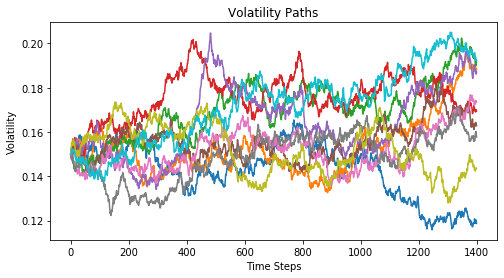


Here are some of the stock price paths, which follow a geometric Brownian motion with stochastic volatility:


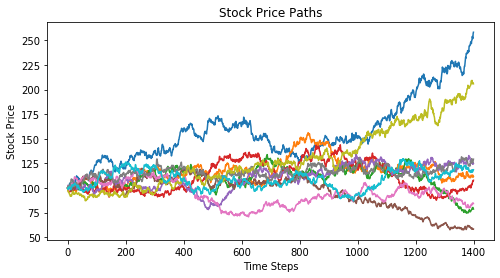


And here is the distribution of the options prices:


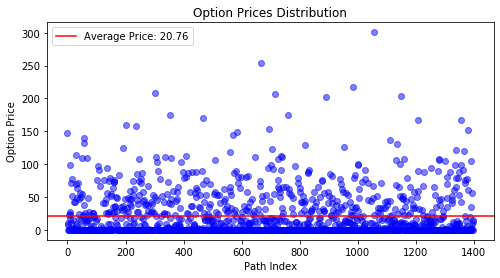

By taking the mean of the simulated options prices, the Heston model prices the option at $20.757390142919093


20.757390142919093

In [14]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.15, dividend_yield = 0, is_call = True, option_type="European")
h = HestonModel(option = o, risk_free_rate = 0.07, kappa = 2, theta = 0.17, sigma = 0.1, rho = -0.5)
h.get_price()

As we can, the model outputs 3 graphs:
- **Vol paths**: Firstly, the model outputs a graph of some of the volatility paths produced in the simulation. These volatility paths are producing using the mean-reverting square root stochastic process described earlier.
- **Stock price paths**: Next, the model outputs a graph of some of the stock price paths produced in the simulation. These stock price paths are producing using the Geometric Brownian motion process described earlier, and allow for stochastic volatility.
- **Option prices distribution**: Lastly, the model outputs a graph of the option prices distribution, which allows for interpretability of the MC simulation and shows how the average price was determined.

Next, let's test the model on the same European call, but increase the value of $\theta$ from 0.17 to 0.35, which indicates the long-term volatility.

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:14<00:00, 97.23it/s]


After generating 1400 Heston paths, here are some of the volatility paths, which follow a mean-reverting square root random process:


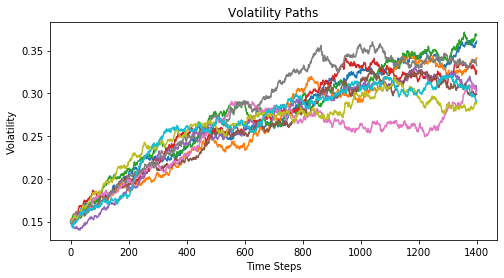


Here are some of the stock price paths, which follow a geometric Brownian motion with stochastic volatility:


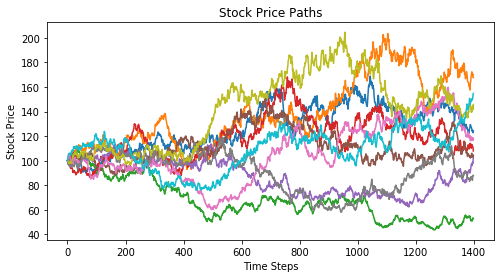


And here is the distribution of the options prices:


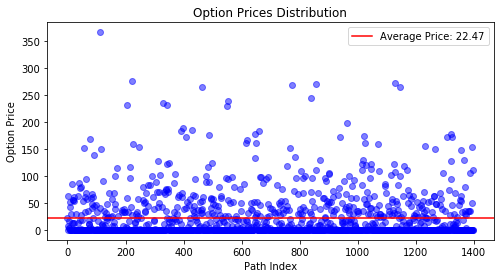

By taking the mean of the simulated options prices, the Heston model prices the option at $22.473375486493445


22.473375486493445

In [15]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.15, dividend_yield = 0, is_call = True, option_type="European")
h = HestonModel(option = o, risk_free_rate = 0.07, kappa = 2, theta = 0.35, sigma = 0.1, rho = -0.5)
h.get_price()

The output of the model shows that the volatility paths are much more increasing now, which makes sense given that volatility paths are produced via mean reversion, and a higher value of $\theta$ would thus lead to higher volatilities. Our model correctly identifies that the option should now be priced higher, as increased volatility makes an option more valuable since there is more potential upside. This is a clear example of how the volatility paths graph greatly increases the interpretability of the final price.

Now, let's test our model on a European put:

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:14<00:00, 99.90it/s]


After generating 1400 Heston paths, here are some of the volatility paths, which follow a mean-reverting square root random process:


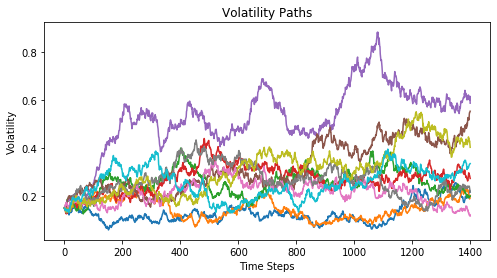


Here are some of the stock price paths, which follow a geometric Brownian motion with stochastic volatility:


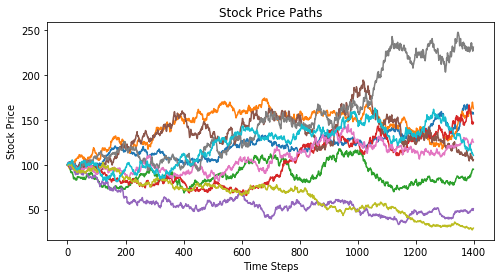


And here is the distribution of the options prices:


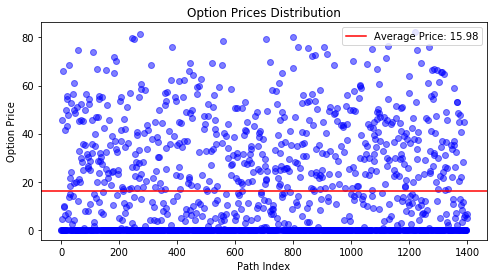

By taking the mean of the simulated options prices, the Heston model prices the option at $15.977588520992127


15.977588520992127

In [16]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.15, dividend_yield = 0, is_call = False, option_type="European")
h = HestonModel(option = o, risk_free_rate = 0.07, kappa = 2, theta = 0.35, sigma = 0.5, rho = -0.5)
h.get_price()

Once again, our model outputs the 3 graphs which explain its decision-making and pricing logic. Finally, we test out model on the exact same put but lower the value of kappa from 2 to 0.5:

100%|█████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:13<00:00, 103.77it/s]


After generating 1400 Heston paths, here are some of the volatility paths, which follow a mean-reverting square root random process:


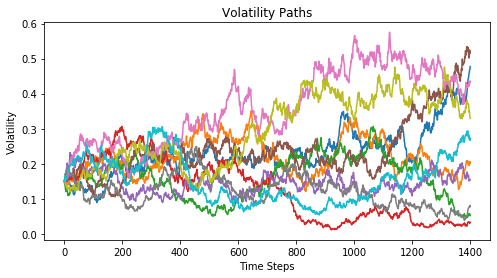


Here are some of the stock price paths, which follow a geometric Brownian motion with stochastic volatility:


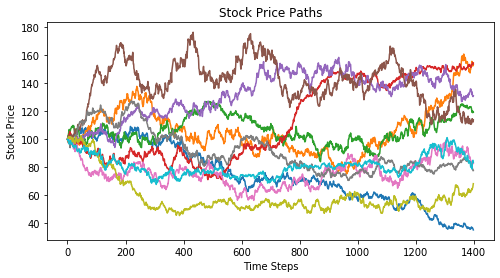


And here is the distribution of the options prices:


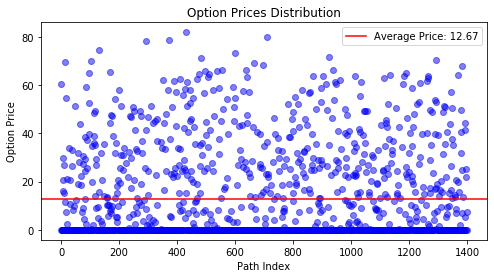

By taking the mean of the simulated options prices, the Heston model prices the option at $12.672129516807603


12.672129516807603

In [17]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.15, dividend_yield = 0, is_call = False, option_type="European")
h = HestonModel(option = o, risk_free_rate = 0.07, kappa = 0.5, theta = 0.35, sigma = 0.5, rho = -0.5)
h.get_price()

We can see that lowering the value of kappa has made our option price cheaper. This makes sense, as kappa controls the rate of mean reversion; if mean reversion is slower, then volatility will take longer to go up, which will reduce the value of the put. This is reflected in the stock paths graph, as volatility growth is less steep in this graph than the last one.

# Pricing Digital Options

Digital options, also known as binary options, are a type of exotic option with a payout that is either a fixed amount (which we assume to be $1, but it can easily be scaled) or nothing at all, depending on whether the option expires in the money. Although simpler in payout, digital options are classified as exotic because they aren't standardized and have unique features compared to plain vanilla options.

## The Monte Carlo Simulation Approach
The `DigitalOptionPricer` class employs a Monte Carlo simulation to estimate the price of a digital option. This involves simulating the path of the underlying asset's price and determining the frequency with which the option ends in the money.

## Mathematical Process
The terminal stock price at expiration is modeled using a log-normal distribution, assuming that returns are normally distributed:

$$
S_T = S_0 \cdot e^{(r - \frac{\sigma^2}{2})T + \sigma \sqrt{T} Z}
$$

where:
- $S_0$ is the initial stock price.
- $r$ is the risk-free interest rate.
- $T$ is the time to expiration.
- $\sigma$ is the volatility of the stock.
- $Z$ is a standard normal random variable.

Given the terminal stock prices, we count the number of times the option expires in the money (either $S_T > K$ for calls or $S_T < K$ for puts) and use this to estimate the option's value:

$$
\text{Option Price} = e^{-rT} \times \frac{\text{Number of Paths In The Money}}{\text{Total Number of Paths}}
$$

## Visualization
We include visualizations to display the distribution of terminal stock prices and the scatter plot of simulated option payouts, providing insights into the behavior of the digital option's exotic payout structure.


In [18]:
class DigitalOptionPricer:
    """
    A class to price digital (binary) options using Monte Carlo simulation. This pricer assumes a
    log-normal distribution for the underlying asset's price movement over the option's lifetime.
    """
    def __init__(self, option, risk_free_rate, num_trials=100000):
        """
        Initializes the digital option pricer.

        Args:
            option (Option): The digital option to be priced. Must be of type 'Digital'.
            risk_free_rate (float): The risk-free interest rate for discounting the option payoff.
            num_trials (int): The number of simulation trials to estimate the option price.
        
        Raises:
            ValueError: If the option is not of type 'Digital'.
        """
        self.option = option  # The digital option object containing all relevant parameters.
        if self.option.option_type != "Digital":
            raise ValueError("This model only works for Digital options.")
        self.r = risk_free_rate  # The annual risk-free rate used for discounting.
        self.num_trials = num_trials  # The number of price paths to simulate.

    def get_price(self):
        """
        Estimates the price of a digital option using Monte Carlo simulation.

        Returns:
            float: The estimated price of the digital option.
        """
        o = self.option
        # Generate random price increments and calculate the terminal stock prices.
        increments = ss.norm.rvs(loc=0, scale=o.vol, size=self.num_trials)
        returns = np.exp(o.T * (self.r - o.vol ** 2 / 2) + increments)
        S_T = o.S0 * returns

        # Calculate the number of simulations where the option finishes in the money.
        if o.is_call:
            num_itm = np.sum(S_T > o.K)
            price = np.exp(-self.r * o.T) * num_itm / self.num_trials
        else:
            num_itm = np.sum(S_T < o.K)
            price = np.exp(-self.r * o.T) * num_itm / self.num_trials

        # Visualize the results of the simulation.
        self.visualize_terminal_prices(S_T, num_itm)
        print(f'By taking the mean of the simulated options prices, the model prices the Digital option at ${price}')
        return price

    def visualize_terminal_prices(self, S_T, num_itm):
        """
        Visualizes the terminal stock prices and their relation to the option's strike price.
        Displays the frequency of in-the-money occurrences and the distribution of simulated option payouts.

        Args:
            S_T (np.array): Simulated terminal stock prices.
            num_itm (int): Number of simulations where the option is in the money.
        """
        o = self.option
        print(f'Looking at the graph below, {num_itm} out of the {self.num_trials} simulated stock prices were In The Money, meaning that the holder would exercise their right and make a profit.')
        
        # Plot a histogram of the terminal stock prices and highlight the in-the-money area.
        plt.figure(figsize=(10, 6))
        plt.hist(S_T, bins=50, alpha=0.6, color='blue', label='Terminal Stock Prices')
        plt.axvline(x=o.K, color='red', linestyle='--', linewidth=2, label='Strike Price (K)')
        
        if o.is_call:
            plt.fill_betweenx([0, plt.ylim()[1]], o.K, max(S_T), color='green', alpha=0.6, label='ITM Area for Calls')
        else:
            plt.fill_betweenx([0, plt.ylim()[1]], min(S_T), o.K, color='red', alpha=0.3, label='ITM Area for Puts')
        
        plt.xlabel('Terminal Stock Price (S_T)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Show a scatter plot of the simulated option payouts.
        payouts = np.where(S_T > o.K if o.is_call else S_T < o.K, np.exp(-self.r * o.T), 0)
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(S_T)), payouts, color='blue', alpha=0.5, label='Simulated Option Prices')
        plt.axhline(y=np.mean(payouts), color='red', linestyle='--', label=f'Average Payout: {np.mean(payouts):.2f}')
        plt.xlabel('Simulation Index')
        plt.ylabel('Option Payout')
        plt.legend()
        plt.grid(True)
        plt.show()

# Testing the Model - Black-Scholes Formulas

By comparing the prices given by these Black-Scholes formulas to those generated by our simulation-based pricer, we can assess the accuracy of our Monte Carlo approach.

## Digital Call Option
A Digital call option pays out a fixed amount if the underlying asset price is above the strike price at expiration. The Black-Scholes price for a Digital call option is calculated as follows:

$$
\text{Digital Call Price} = e^{-rT} N(d_2)
$$

where:
- $N$ is the cumulative distribution function of the standard normal distribution.
- $e^{-rT}$ is the discount factor for the risk-free rate over the life of the option.
- $d_2$ is calculated by the formula:

$$
d_2 = \frac{\ln\left(\frac{S}{K}\right) + \left(r - \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}
$$

## Digital Put Option
Conversely, a Digital put option pays out if the underlying asset price is below the strike price at expiration. The price for a Digital put option is:

$$
\text{Digital Put Price} = e^{-rT} N(-d_2)
$$

In [19]:
def d2(S, K, T, r, sigma):
    return (np.log(S/K) + (r- sigma**2 / 2)*T) /  (sigma*np.sqrt(T))

# Calculate the price of a digital call option using Black-Scholes formula.
def BS_digital_call(S, K, T, r, sigma):
    N = ss.norm.cdf
    return np.exp(-r*T)* N(d2(S,K,T,r,sigma))

# Calculate the price of a digital put option using Black-Scholes formula.
def BS_digital_put(S, K, T, r, sigma):
    N = ss.norm.cdf
    return np.exp(-r*T)* N(-d2(S,K,T,r,sigma))

Let's test our model on a Digital call option:

Looking at the graph below, 48654 out of the 100000 simulated stock prices were In The Money, meaning that the holder would exercise their right and make a profit.


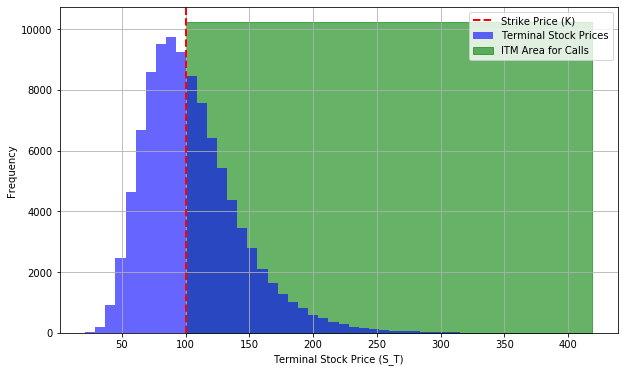

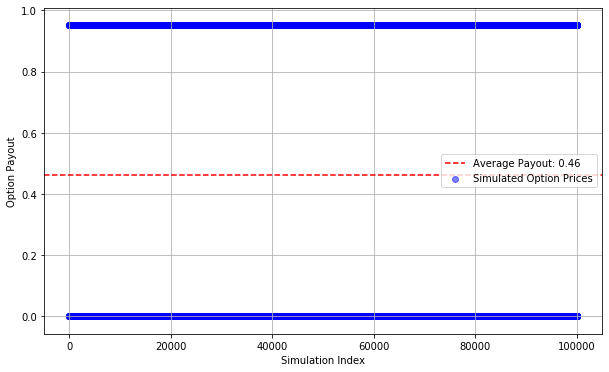

By taking the mean of the simulated options prices, the model prices the Digital option at $0.46281116419657736


Black-Scholes prices the option at $0.4634190597240727


In [20]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.35, is_call = True, option_type="Digital")
p = DigitalOptionPricer(option = o, risk_free_rate = 0.05)
p.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_digital_call(o.S0, o.K, o.T, p.r, o.vol)}')

As we can see, the model outputs 2 graphs:
- **Terminal stock prices**: The model outputs a graph that shows the distribution of terminal stock prices and which are in the money and would be exercised.
- **Option prices distribution**: The model also outputs a graph of the option prices distribution, which allows for interpretability of the MC simulation and shows how the average price was determined.

This allows for explainability, since it becomes easy to see how often the digital call was in the money. The options price graph also shows that there is a balancing act between the option being exercised for the fixed amount of profit or becoming worthless. Also, we can see that our model produced nearly the same price as the Black-Scholes formula, so we know it is correct. Now, let's test our model on the same Digital call but reduce the strike price to 65:

Looking at the graph below, 88342 out of the 100000 simulated stock prices were In The Money, meaning that the holder would exercise their right and make a profit.


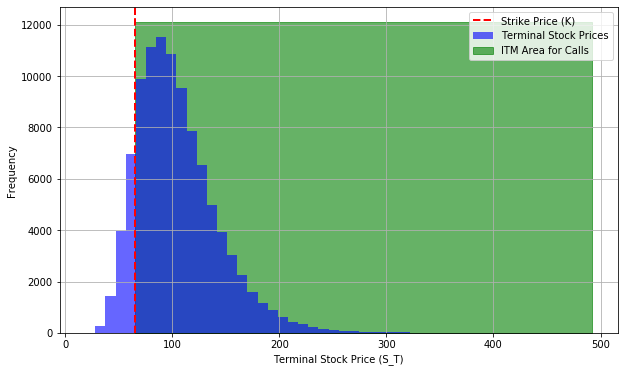

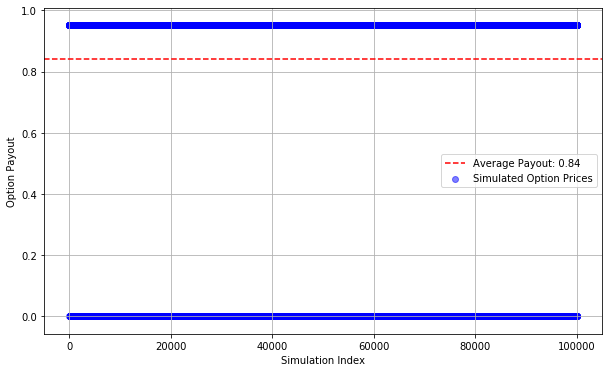

By taking the mean of the simulated options prices, the model prices the Digital option at $0.8403350981924208


Black-Scholes prices the option at $0.8415250633822047


In [21]:
o = Option(spot_price = 100, strike = 65, maturity = 1, volatility = 0.35, is_call = True, option_type="Digital")
p = DigitalOptionPricer(option = o, risk_free_rate = 0.05)
p.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_digital_call(o.S0, o.K, o.T, p.r, o.vol)}')

Once again, our model outputs the graphs for interpretability and the price is consistent with the price from the Black-Scholes formula. Additionally, we can see that decreasing the Strike price has increase the price of the call, which makes sense as the call will now have a much higher chance of ending in the money.

Now, let's test our model on a Binary put option:

Looking at the graph below, 51435 out of the 100000 simulated stock prices were In The Money, meaning that the holder would exercise their right and make a profit.


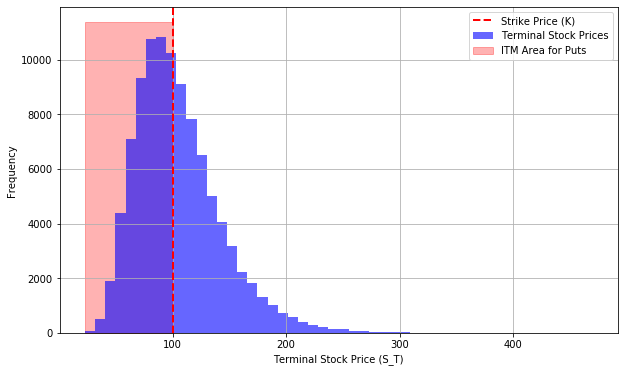

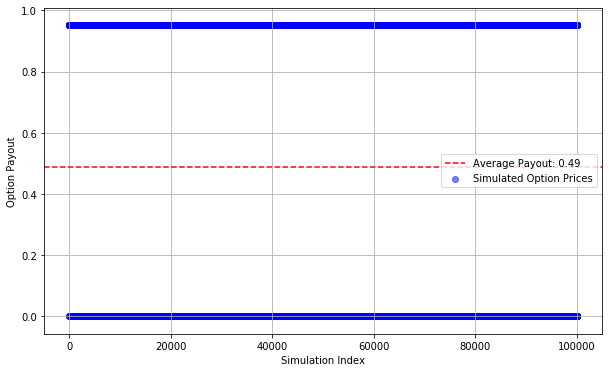

By taking the mean of the simulated options prices, the model prices the Digital option at $0.48926485449194224


Black-Scholes prices the option at $0.4878103647766413


In [22]:
o = Option(spot_price = 100, strike = 100, maturity = 1, volatility = 0.35, is_call = False, option_type="Digital")
p = DigitalOptionPricer(option = o, risk_free_rate = 0.05)
p.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_digital_put(o.S0, o.K, o.T, p.r, o.vol)}')

As we can see, our model now shows how many of the simulated terminal stock prices are in the money via the red shading, and we can see the balancing act of pricing in the options price graph. Once again, it outputs the correct price, so we know it works for Digital puts. Now, let's test it on the same Digital put option but with a much lower Strike price:

Looking at the graph below, 7610 out of the 100000 simulated stock prices were In The Money, meaning that the holder would exercise their right and make a profit.


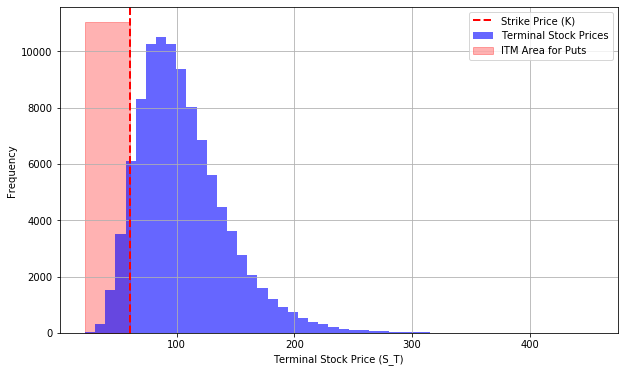

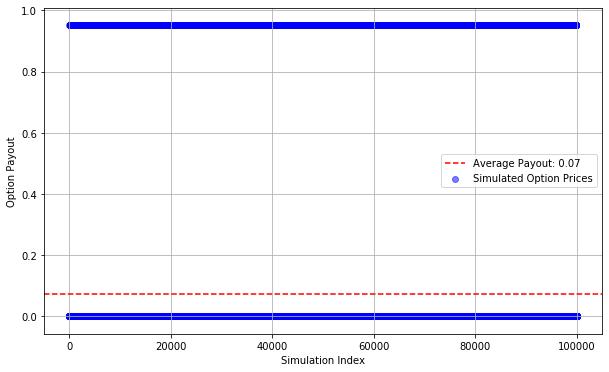

By taking the mean of the simulated options prices, the model prices the Digital option at $0.07238855920450434


Black-Scholes prices the option at $0.07299566423834639


In [23]:
o = Option(spot_price = 100, strike = 60, maturity = 1, volatility = 0.35, is_call = False, option_type="Digital")
p = DigitalOptionPricer(option = o, risk_free_rate = 0.05)
p.get_price()
print(f'\n\nBlack-Scholes prices the option at ${BS_digital_put(o.S0, o.K, o.T, p.r, o.vol)}')

As we can see, the model is once again correct with its price. Furthermore, the model correctly prices the Digital put lower, as significantly decreasing the Strike price means that the option will almost never be in the money.

# Barrier Option Pricing Model

Barrier options are exotic options that are unique in that their payoff depends on whether the underlying asset's price reaches a pre-defined barrier level during the option's life. The `BarrierOptionPricer` class in this project simulates the paths of an underlying asset using geometric Brownian motion to determine the payoff of barrier options under different conditions. 

## Understanding Barrier Options
Barrier options come in various types:
- **Up and In**: Becomes active if the asset's price goes above the barrier.
- **Up and Out**: Expires if the asset's price goes above the barrier.
- **Down and In**: Becomes active if the asset's price drops below the barrier.
- **Down and Out**: Expires if the asset's price drops below the barrier.

These options are path-dependent, meaning that their value at expiration depends not just on the final price of the underlying asset but also on whether certain levels were breached during the life of the option.

## Pricing Methodology
The pricing method simulates stock price paths using the formula for geometric Brownian motion:

$$
dS_t = r S_t dt + \sigma S_t dW_t,
$$

where $r$ is the risk-free rate, $\sigma$ is the volatility, and $dW_t$ represents the increments of a Wiener process (standard Brownian motion).

### Steps in the Simulation:
1. **Generate Paths**: Simulate paths for the underlying asset's prices up to the expiration date using the discretized version of the geometric Brownian motion equation.
2. **Calculate Payoffs**: For each path, determine if the barrier condition was met (crossed) and compute the payoff accordingly.
3. **Apply Barrier Adjustment**: Adjust the barrier by a factor derived from the Riemann zeta function to account for discretization error:

   $$
   \text{Adjusted Barrier} = B e^{\pm \beta_1 \sigma \sqrt{\Delta t}},
   $$
   
   where $\beta_1 = -\frac{\zeta(1/2)}{\sqrt{2\pi}}$ and $B$ is the original barrier level.

### Payoff Calculation:
The payoffs are calculated based on the barrier type. For 'Out' types, the option expires worthless if the barrier is breached, while for 'In' types, the option only becomes active if the barrier is crossed.

## Visualization and Output
The model visualizes the stock price paths and highlights whether the barrier was crossed. It also plots the distribution of the option prices at maturity, providing a visual representation of the option's value across different simulations. It also gives a short explanation about what crossing the barrier entails for the specific barrier type.

In [24]:
from scipy.special import zeta

class BarrierOptionPricer:
    """
    A pricer for barrier options that simulates the path of the underlying asset using the
    geometric Brownian motion and evaluates the payoff depending on whether the asset price
    crosses a predefined barrier.
    """
    def __init__(self, option, risk_free_rate, barrier_type, num_time_steps=5000, num_paths=30000):
        """
        Initializes the BarrierOptionPricer with the specified option and simulation parameters.

        Parameters:
            option (Option): The option containing necessary attributes like strike price, barrier, etc.
            risk_free_rate (float): The continuously compounded risk-free rate.
            barrier_type (str): The type of barrier ('Up and In', 'Up and Out', 'Down and In', 'Down and Out').
            num_time_steps (int): Number of time steps in the path simulation.
            num_paths (int): Number of paths to simulate.
        """
        self.option = option
        if self.option.option_type != "Barrier":
            raise ValueError("This model only works for Barrier options.")        
        self.r = risk_free_rate
        self.barrier_type = barrier_type
        self.num_time_steps = num_time_steps
        self.num_paths = num_paths
    
    def get_price(self):
        """
        Simulates multiple paths for the underlying asset's price to calculate the price of the barrier option.
        
        Returns:
            float: The calculated price of the barrier option.
        """
        o = self.option
        
        dt = float(o.T / self.num_time_steps)
        
        # Initial values for stock price paths
        initial_values = np.zeros((self.num_paths, 1))
        increments = ss.norm.rvs(loc=(self.r - o.vol ** 2 / 2) * dt, 
                                 scale=np.sqrt(dt) * o.vol, 
                                 size=(self.num_paths, self.num_time_steps - 1))
        X = np.concatenate((initial_values, increments), axis=1).cumsum(1)
        stock_prices = o.S0 * np.exp(X)
        
        # Determine maximum and minimum stock prices for each path
        path_maxima = np.amax(stock_prices, axis=1)
        path_minima = np.amin(stock_prices, axis=1)
        
        # Adjustment factor for the barrier to account for the discretization error
        beta1 = -zeta(1/2) / np.sqrt(2 * np.pi)
        if "Up" in self.barrier_type:
            adjusted_barrier = o.barrier * np.exp(-beta1 * np.sqrt(dt) * o.vol)
        elif "Down" in self.barrier_type:
            adjusted_barrier = o.barrier * np.exp(beta1 * np.sqrt(dt) * o.vol)


        if o.is_call:
            payoffs = np.maximum(stock_prices[:, -1] - o.K, 0)
        else:
            payoffs = np.maximum(o.K - stock_prices[:, -1], 0)

        # Apply the barrier condition
        if "Out" in self.barrier_type:
            payoff_condition = payoffs * (path_maxima < adjusted_barrier if "Up" in self.barrier_type else path_minima > adjusted_barrier)
        else:  
            payoff_condition = payoffs * (path_maxima >= adjusted_barrier if "Up" in self.barrier_type else path_minima <= adjusted_barrier)
        
        # Calculate average simulated price 
        option_price = np.exp(-self.r * o.T) * np.mean(payoff_condition)
        
        if "Up" in self.barrier_type:
            crossing_paths = np.sum(path_maxima >= adjusted_barrier)
        elif "Down" in self.barrier_type:
            crossing_paths = np.sum(path_minima <= adjusted_barrier)
        
        # Print out a message about the barrier condition for the option type
        crossing_message = self.explain_barrier_crossing(o.is_call, self.barrier_type)
        print(f'Out of {self.num_paths} paths, {crossing_paths} crossed the barrier. {crossing_message}\n')
        
        # Print out 20 of the stock paths
        print(f'{min(self.num_paths, 20)} of the stock price paths, which follow a Geometric Brownian motion random process, can be seen below.')
        plt.figure(figsize=(10, 6))
        for i in range(min(self.num_paths, 20)):
            plt.plot(stock_prices[i], lw=1)

        if "Up" in self.barrier_type:
            plt.axhline(y=o.barrier, color='r', linestyle='--', label='Up Barrier')
        elif "Down" in self.barrier_type:
            plt.axhline(y=o.barrier, color='g', linestyle='--', label='Down Barrier')

        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
        # Print out the distribution of the options prices with the mean price
        print("Below is the distribution of the option prices: ")
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(payoff_condition)), np.exp(-self.r * o.T) * payoff_condition, color='blue', alpha=0.5, label='Option Prices at Maturity', s=4)
        plt.axhline(y=np.exp(-self.r * o.T) * np.mean(payoff_condition), color='r', linestyle='--', label=f'Average Option Price: {np.exp(-self.r * o.T) * np.mean(payoff_condition):.2f}')
        plt.xlabel('Path Index')
        plt.ylabel('Option Price')
        plt.legend()
        plt.show()
        
        print(f'By taking the mean of the simulated options prices, the model prices the Barrier option at ${option_price}')
        return option_price
    
    def explain_barrier_crossing(self, is_call, barrier_type):
        """
        Provides an explanation for the implications of the asset price crossing the barrier.

        Parameters:
            is_call (bool): True if the option is a call, False if it's a put.
            barrier_type (str): Specifies the type of barrier option.

        Returns:
            str: Description of what crossing the barrier means for the option's payoff.
        """
        if is_call:
            if barrier_type == "Up and In":
                explanation = "For an Up and In call option, crossing the barrier activates the option. It becomes eligible for exercise only if the stock price moves above this barrier during the option's lifetime."
            elif barrier_type == "Up and Out":
                explanation = "For an Up and Out call option, crossing the barrier deactivates the option. It becomes worthless if the stock price exceeds this barrier, and can otherwise be exercised."
            elif barrier_type == "Down and In":
                explanation = "For a Down and In call option, crossing the barrier activates the option. It becomes eligible for exercise if the stock price dips below this barrier, and is worthless otherwise."
            elif barrier_type == "Down and Out":
                explanation = "For a Down and Out call option, crossing the barrier deactivates the option. If the stock price falls below this barrier, the option is nullified, but it can be exercised otherwise."
        else:  
            if barrier_type == "Up and In":
                explanation = "For an Up and In put option, the barrier crossing activates the option. It becomes active if the stock price rises above this barrier, but is worthless otherwise."
            elif barrier_type == "Up and Out":
                explanation = "For an Up and Out put option, crossing the barrier deactivates the option. This occurs when the stock price climbs above the barrier, but it can be exercised otherwise."
            elif barrier_type == "Down and In":
                explanation = "For a Down and In put option, the barrier crossing activates the option. It’s specifically designed to come into play when the stock price falls below a set level, but is worthless otherwise."
            elif barrier_type == "Down and Out":
                explanation = "For a Down and Out put option, crossing the barrier leads to deactivation. This option becomes void if the stock price goes below the barrier, but can otherwise be exercised."

        return explanation

# Testing Barrier Option Pricing with Black-Scholes Formulas

To ensure the reliability and accuracy of our Monte Carlo-based barrier option pricer, we complement our simulations with explicit pricing formulas derived from the Black-Scholes model.

## Key Concepts

- **In-Out Parity**: In barrier options, the sum of the prices of an 'in' option and an 'out' option for the same type (call or put) equals the price of a corresponding vanilla option. 
  - For calls: $\text{Call}_{\text{up-in}} + \text{Call}_{\text{up-out}} = \text{Vanilla Call}$ and $\text{Call}_{\text{down-in}} + \text{Call}_{\text{down-out}} = \text{Vanilla Call}$   
  - For puts: $\text{Put}_{\text{up-in}} + \text{Put}_{\text{up-out}} = \text{Vanilla Put}$ and $\text{Put}_{\text{down-in}} + \text{Put}_{\text{down-out}} = \text{Vanilla Put}$

- **Barrier and Strike Relationship**: The formulas vary depending on whether the barrier (B) is above or below the strike price (K), which affects the perceived risk and potential return of the option.

## Sample Formula

There are too many formulas to list here (and they are quite complicated), so we include one sample. Consider the formula for an 'Up and Out' call option where the barrier is above the strike price:
- The price of the 'Up and Out' call is given by:
  $$
  \text{Call}_{\text{up-out}}(S_0, K, T, r, \sigma, B) = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2) - \left[ S_0 \left( \frac{B}{S_0} \right)^{2\lambda} N(-y) - K \cdot e^{-rT} \left( \frac{B}{S_0} \right)^{2\lambda - 2} N(-y + \sigma \sqrt{T}) \right]
  $$
  where:
  - $\lambda = \frac{r - q + \sigma^2 / 2}{\sigma^2}$
  - $y = \ln \left(\frac{B^2}{S_0 \cdot K}\right) / (\sigma \sqrt{T}) + \lambda \sigma \sqrt{T}$
  - $N(\cdot)$ is the cumulative distribution function of the standard normal distribution.

This formula calculates the price by considering the probability of the stock price reaching the barrier during the option's lifetime and adjusting the payout accordingly.

In [25]:
def barrier_explicit_formula(S0, K, T, r, sigma, B, is_call, barrier_type='Up and Out', q=0):
    """
    Calculates the price of a barrier option using an explicit formula based on the Black-Scholes model.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier level.
        is_call (bool): True if the option is a call, False if it is a put.
        barrier_type (str): Specifies whether the barrier is 'Up and Out', 'Down and Out', 'Up and In', or 'Down and In'.
        q (float): Dividend yield of the underlying asset.

    Returns:
        float: The price of the barrier option.

    Note: to make some computations easier and reduce the amount of gross code, the Barrier option equivalent of put-call
    parity is used where appropriate.
    """
    
    # Calculate the standard Black-Scholes prices for vanilla options (needed for put call parity)
    vanilla_call = BS_call(S0, K, T, r, q, sigma)
    vanilla_put = BS_put(S0, K, T, r, q, sigma)
    
    # Calculate auxiliary variables for the barrier option formula.
    lambda_ = (r - q + sigma ** 2 / 2) / sigma ** 2
    y = (np.log(B ** 2 / (S0 * K))) / (sigma * np.sqrt(T)) + (lambda_ * sigma * np.sqrt(T))
    x1 = np.log(S0 / B) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(B / S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    if is_call:
        # Up and In/Up and Out calls
        if "Up" in barrier_type:
            # Note: the price will be different depending on the relationship between the Strike and barrier.
            if B >= K:
                in_price = max((S0 * np.exp(-q * T) * ss.norm.cdf(x1) - K * np.exp(-r * T) * 
                                ss.norm.cdf(x1 - sigma * np.sqrt(T)) - S0 * np.exp(-q * T) * (B / S0) ** (2 * lambda_) 
                                * (ss.norm.cdf(-y) - ss.norm.cdf(-y1)) + K * np.exp(-r * T) 
                                * (B / S0) ** (2 * lambda_ - 2) * (ss.norm.cdf(-y + sigma * np.sqrt(T)) 
                                - ss.norm.cdf(-y1 + sigma * np.sqrt(T)))), 0)
                # PC parity
                out_price = vanilla_call - in_price
            else:
                out_price = 0
                # PC parity
                in_price = vanilla_call - out_price
                
        # Down and In/Down and Out calls
        if "Down" in barrier_type:
            if B >= K:
                out_price = max((S0 * np.exp(-q * T) * ss.norm.cdf(x1) - K * np.exp(-r * T) *
                                 ss.norm.cdf(x1 - sigma * np.sqrt(T)) - S0 * np.exp(-q * T) * (B / S0) ** (2 * lambda_) 
                                 * ss.norm.cdf(y1) + K * np.exp(-r * T) * (B / S0) ** (2 * lambda_ - 2) 
                                 * ss.norm.cdf(y1 - sigma * np.sqrt(T))), 0,)
                in_price = vanilla_call - out_price
            else:
                in_price = max((S0 * np.exp(-q * T) * (B / S0) ** (2 * lambda_)
                                * ss.norm.cdf(y) - K * np.exp(-r * T) * (B / S0) ** (2 * lambda_ - 2) 
                                * ss.norm.cdf(y - sigma * np.sqrt(T))), 0)
                out_price = vanilla_call - in_price
    else:
        # Up and In/Up and Out puts
        if "Up" in barrier_type:
            if B >= K:
                in_price = max((-S0 * np.exp(-q * T) * (B / S0) ** (2 * lambda_) * 
                                ss.norm.cdf(-y) + K * np.exp(-r * T) * (B / S0) ** (2 * lambda_ - 2) 
                                * ss.norm.cdf(-y + sigma * np.sqrt(T))), 0)
                out_price = vanilla_put - in_price
            else:
                out_price = max((-S0 * np.exp(-q * T) * ss.norm.cdf(-x1) + K 
                                 * np.exp(-r * T) * ss.norm.cdf(-x1 + sigma * np.sqrt(T)) - S0 * np.exp(-q * T) 
                                 * (B / S0) ** (2 * lambda_) * ss.norm.cdf(-y) - K * np.exp(-r * T) 
                                 * (B / S0) ** (2 * lambda_ - 2) * ss.norm.cdf(-y1 + sigma * np.sqrt(T))), 0)
                in_price = vanilla_put - out_price
                
        # Down and In/Down and Out puts    
        if "Down" in barrier_type:
            if B >= K:
                out_price = 0
                in_price = vanilla_put - out_price
            else:
                in_price = max((-S0 * np.exp(-q * T) * ss.norm.cdf(-x1) + K * np.exp(-r * T) 
                                * ss.norm.cdf(-x1 + sigma * np.sqrt(T)) + S0 * np.exp(-q * T) * (B / S0) ** (2 * lambda_) 
                                * (ss.norm.cdf(y) - ss.norm.cdf(y1)) - K * np.exp(-r * T) * (B / S0) ** (2 * lambda_ - 2) 
                                * (ss.norm.cdf(y - sigma * np.sqrt(T)) - ss.norm.cdf(y1 - sigma * np.sqrt(T)))), 0)
                out_price = vanilla_put - in_price
    
    # return price depending on type of barrier option
    if "Out" in barrier_type:
        price = out_price
    else:
        price = in_price
    
    return price


Now, we can test our model. Let's first test it on an Up and Out call option:

Out of 30000 paths, 11700 crossed the barrier. For an Up and Out call option, crossing the barrier deactivates the option. It becomes worthless if the stock price exceeds this barrier, and can otherwise be exercised.

20 of the stock price paths, which follow a Geometric Brownian motion random process, can be seen below.


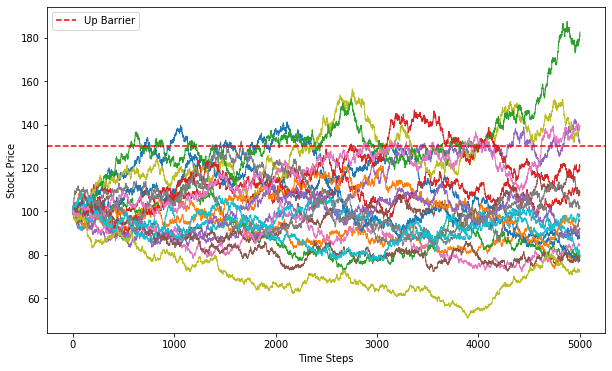

Below is the distribution of the option prices: 


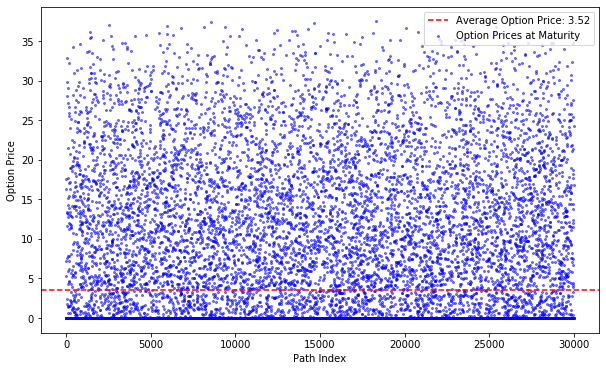

By taking the mean of the simulated options prices, the model prices the Barrier option at $3.5215623449889364


The explicit formula calculates the price of the Barrier option as $3.547874810190592


In [26]:
o = Option(spot_price = 100, strike = 90, maturity = 1, volatility = 0.3, barrier = 130, is_call = True, option_type="Barrier")
p = BarrierOptionPricer(option = o, risk_free_rate = 0.05, barrier_type = "Up and Out")
p.get_price()
exact = barrier_explicit_formula(o.S0, o.K, o.T, p.r, o.vol, o.barrier, o.is_call, p.barrier_type)
print(f'\n\nThe explicit formula calculates the price of the Barrier option as ${exact}')

Immediately, we see that our model's price is quite close to the explicit formula's price, indicating that it is working correctly.

The model outputs 2 graphs:
- **Stock price paths**: The model outputs a graph that shows the paths of the stock prices, which follow a Geometric Brownian Motion random process. This graph clearly shows the barrier and makes it easy to see examples of stock price paths that crossed the barrier and did not cross the barrier.
- **Option prices distribution**: The model also outputs a graph of the option prices distribution, which allows for interpretability of the MC simulation and shows how the average price was determined.

The model also outputs the number of stock price paths that crossed the barrier along with an explanation of what crossing the barrier means for the specific type of barrier option. This makes it easy to understand the option pricing decision, since these two outputs in combination determine whether the option will mostly be exercised or become worthless. In this case, we see that the option is valuable if it does not cross the barrier and the stock price paths show that many do not cross the barrier, thus meaning the option will have a decent amount of value. 

Now, let's test our model on a Down and In barrier put that has a much higher Spot price than barrier:

Out of 30000 paths, 34 crossed the barrier. For a Down and In put option, the barrier crossing activates the option. It’s specifically designed to come into play when the stock price falls below a set level, but is worthless otherwise.

20 of the stock price paths, which follow a Geometric Brownian motion random process, can be seen below.


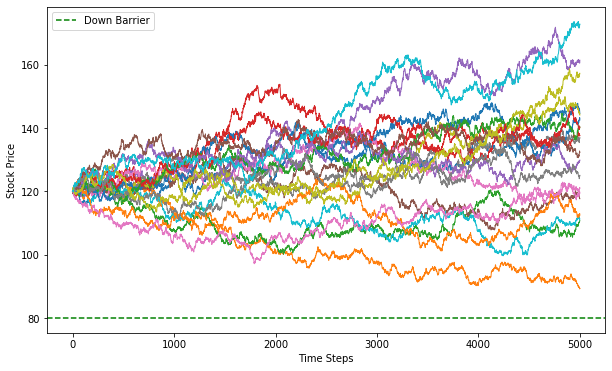

Below is the distribution of the option prices: 


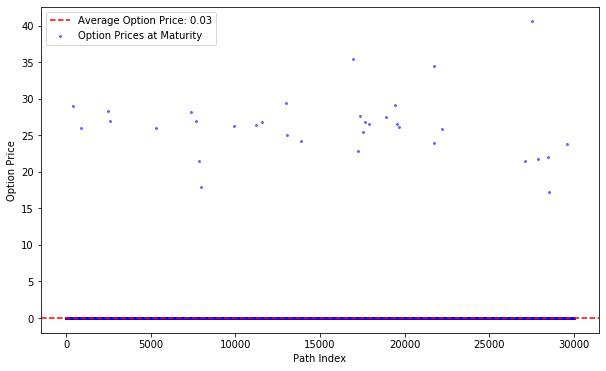

By taking the mean of the simulated options prices, the model prices the Barrier option at $0.029823372162129987


The explicit formula calculates the price of the Barrier option as $0.031050822687375017


In [27]:
o = Option(spot_price = 120, strike = 110, maturity = 1, volatility = 0.15, barrier = 80, is_call = False, option_type="Barrier")
p = BarrierOptionPricer(option = o, risk_free_rate = 0.1, barrier_type = "Down and In")
p.get_price()
exact = barrier_explicit_formula(o.S0, o.K, o.T, p.r, o.vol, o.barrier, o.is_call, p.barrier_type)
print(f'\n\nThe explicit formula calculates the price of the Barrier option as ${exact}')

Once again, our model accurately prices the Barrier option. Furthermore, the model's output explain why the price of this Down and In put is so low - it explains that the option only gets exercised if the price goes below the barrier, and the graph of stock price paths shows that the paths are all much above the barrier, meaning that there is a very low chance that the option will ever be exercised. The graph of the options price distribution complements this by showing that nearly all of the options were worth nothing.

Now, let's test our model on an Up and In call: 

Out of 30000 paths, 24580 crossed the barrier. For an Up and In call option, crossing the barrier activates the option. It becomes eligible for exercise only if the stock price moves above this barrier during the option's lifetime.

20 of the stock price paths, which follow a Geometric Brownian motion random process, can be seen below.


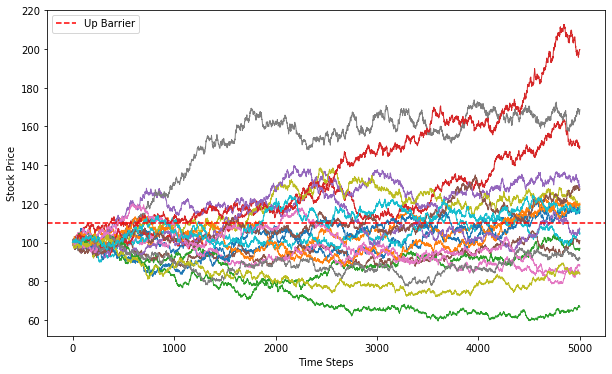

Below is the distribution of the option prices: 


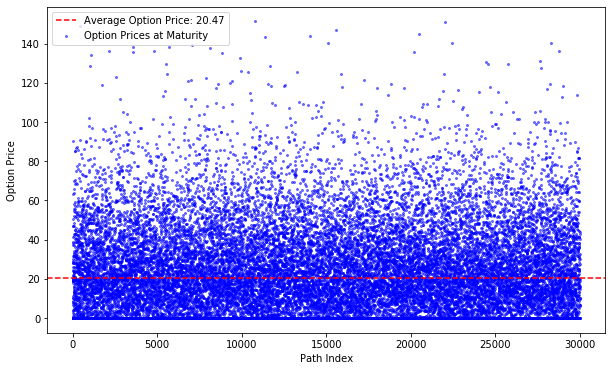

By taking the mean of the simulated options prices, the model prices the Barrier option at $20.474710081719472


The explicit formula calculates the price of the Barrier option as $20.593603431715017


In [28]:
o = Option(spot_price = 100, strike = 95, maturity = 1.5, volatility = 0.2, barrier = 110, is_call = True, option_type="Barrier")
p = BarrierOptionPricer(option = o, risk_free_rate = 0.1, barrier_type = "Up and In")
p.get_price()
exact = barrier_explicit_formula(o.S0, o.K, o.T, p.r, o.vol, o.barrier, o.is_call, p.barrier_type)
print(f'\n\nThe explicit formula calculates the price of the Barrier option as ${exact}')

Once again, our model's price is accurate. Furthermore, the output shows that many of the stock price paths are well above the barrier and there are many simulated options prices that are very high, explaining why the option's price is quite high. Finally, let's test our model on a Down and Out put:

Out of 30000 paths, 1058 crossed the barrier. For a Down and Out put option, crossing the barrier leads to deactivation. This option becomes void if the stock price goes below the barrier, but can otherwise be exercised.

20 of the stock price paths, which follow a Geometric Brownian motion random process, can be seen below.


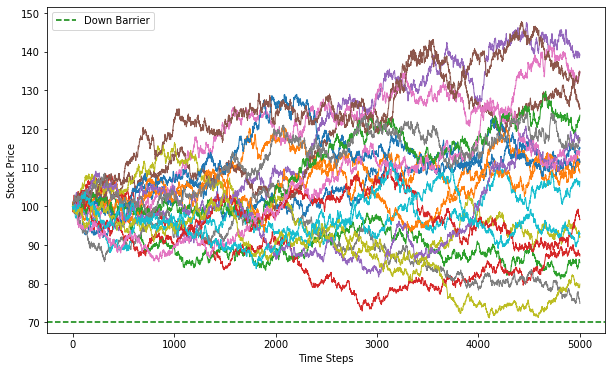

Below is the distribution of the option prices: 


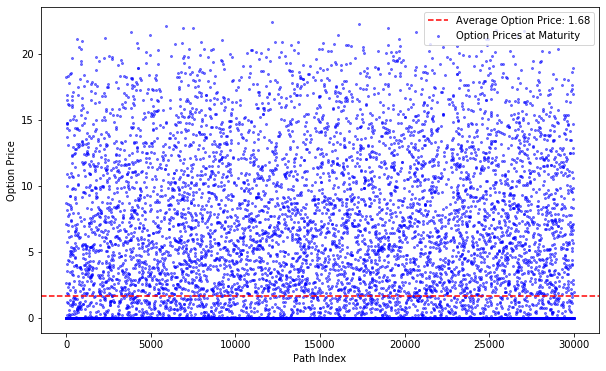

By taking the mean of the simulated options prices, the model prices the Barrier option at $1.6780218909870068


The explicit formula calculates the price of the Barrier option as $1.680327085141484


In [29]:
o = Option(spot_price = 100, strike = 95, maturity = 1, volatility = 0.2, barrier = 70, is_call = False, option_type="Barrier")
p = BarrierOptionPricer(option = o, risk_free_rate = 0.1, barrier_type = "Down and Out")
p.get_price()
exact = barrier_explicit_formula(o.S0, o.K, o.T, p.r, o.vol, o.barrier, o.is_call, p.barrier_type)
print(f'\n\nThe explicit formula calculates the price of the Barrier option as ${exact}')

Again, our model's price is accurate. Furthermore, the stock price path output shows why the option's price is low - the Down and Out option's stock price cannot go too far down or it will deactivate, but it must go down enough for the put to make money. Therefore, there is a low chance that the stock price will end in the perfect range that will lead to a profitable exercise. 

# Thanks so much for the great semester!